# SegNet for Stone Segmentation

This notebook demonstrates how to implement and train a **SegNet** model for stone segmentation. We will:

1. Import dependencies.
2. Load images and masks from the augmented dataset.
3. Build a custom data generator (or simple loader) to feed images/masks to the model.
4. Define a SegNet model using TensorFlow/Keras.
5. Train and evaluate the model.

We will place this notebook as `segnet_chambord.ipynb` inside `notebooks/`. The paths to images and masks will be:
- `../data/annotations/augmented/images`
- `../data/annotations/augmented/masks`


## SegNet
SegNet is a deep convolutional encoder-decoder architecture for semantic pixel-wise segmentation. It uses an encoder to down-sample and a corresponding decoder that up-samples using pooling indices (in the original paper). Here, we'll implement a simplified version of SegNet without argmax-based unpooling, but the idea remains similar.

In [2]:
# !pip install tensorflow

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("scikit-learn version:", tf.__version__)

TensorFlow version: 2.16.2
Keras version: 3.9.0
scikit-learn version: 2.16.2


## Hyperparameters and Paths

In [ ]:
# Define directories for images and masks
IMAGES_DIR = "../data/augmented/images"
MASKS_DIR = "../data/augmented/masks"

# Image details
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
NUM_CLASSES = 2  # we have 2 classes: background and stones (black and white)

# Training parameters
BATCH_SIZE = 4
EPOCHS = 10  
VAL_SPLIT = 0.2  # 20% of data for validation

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1. Loading and Splitting the Dataset

- The `images` folder contains all the input images.
- The `masks` folder contains the corresponding masks with the **same filename** (`image_001.png` to `image_00n.png`)

We'll gather the filenames, split into train/validation sets, and create a simple Python generator to load them in batches.

In [6]:
def load_image(image_path, target_size=(256, 256), grayscale=False):
    """
    Loads an image from disk, resizes it, and converts it to an array.
    Optionally loads in grayscale (useful for masks).
    """
    img = load_img(image_path, target_size=target_size, color_mode='grayscale' if grayscale else 'rgb')
    img_array = img_to_array(img)
    return img_array

image_filenames = sorted(os.listdir(IMAGES_DIR))

# Build full paths
image_paths = [os.path.join(IMAGES_DIR, f) for f in image_filenames]
mask_paths = [os.path.join(MASKS_DIR, f) for f in image_filenames]  # assume same filenames

print("Total images found:", len(image_paths))

Total images found: 4000


### Train/Validation Split

In [7]:
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=VAL_SPLIT, random_state=SEED
)

print("Training set size:", len(train_images))
print("Validation set size:", len(val_images))

Training set size: 3200
Validation set size: 800


## 2. Data Generator
We will define a simple generator that:
- Takes a list of image paths and mask paths.
- Yields batches of `(image_batch, mask_batch)`.
- Rescales images to [0,1].
- Optionally one-hot encodes the masks if we have multiple classes.

> For **binary segmentation** (2 classes), we store masks in a single channel (0 or 1). For **multi-class** segmentation, we store integer labels per pixel and then one-hot encode them.

In [ ]:
def data_generator(image_paths, mask_paths, batch_size, num_classes, input_size=(256,256)):
    """
    Yields batches of (images, masks) for training/validation.
    """
    while True:
        # Shuffle at the beginning of each epoch
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            batch_indices = indices[start:end]

            images = []
            masks = []

            for i in batch_indices:
                img = load_image(image_paths[i], target_size=input_size, grayscale=False)
                mask = load_image(mask_paths[i], target_size=input_size, grayscale=True)

                # Scale images to [0,1]
                img = img / 255.0
                mask = mask / 255.0  # For binary, this will be 0 or 1

                # For binary segmentation, we can keep mask as shape (H, W, 1)
                # If multiple classes, convert to one-hot: e.g. tf.one_hot()
                if num_classes > 2:
                    # Squeeze channel -> shape (H, W)
                    mask = np.squeeze(mask, axis=-1)
                    # Convert to int in case of float rounding
                    mask = mask.astype(np.uint8)
                    # One-hot encode
                    mask = tf.one_hot(mask, num_classes)
                    mask = tf.reshape(mask, (input_size[0], input_size[1], num_classes))
                    mask = mask.numpy()
                else:
                    # Binary case: keep single channel with values 0 or 1
                    # ensure 0/1 by thresholding 
                    mask = (mask > 0.5).astype(np.float32)  # shape (H, W, 1)
                    

                images.append(img)
                masks.append(mask)

            images = np.array(images, dtype=np.float32)
            masks = np.array(masks, dtype=np.float32)

            yield images, masks

## 3. Defining the SegNet Model
Below is a simplified version of the SegNet architecture using Keras. We use standard `Conv2D`, `BatchNormalization`, and `MaxPooling2D` for the encoder, then mirror it with `Conv2DTranspose` and `Conv2D` in the decoder.

> **Note**: The original SegNet uses argmax indices to unpool. Here, we use simpler `UpSampling2D` or `Conv2DTranspose` for demonstration.


In [12]:
def segnet(input_shape=(256, 256, 3), num_classes=2):
    """
    A simplified SegNet architecture.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Decoder
    x = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Final layer
    # For multi-class, we use 'num_classes' filters and softmax activation.
    # For binary, we can use 1 filter with sigmoid activation.
    if num_classes == 2:
        # binary segmentation
        x = layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)
    else:
        # multi-class segmentation
        x = layers.Conv2D(num_classes, (1,1), padding='same', activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

# Instantiate the model
model = segnet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 256)    │             

 Total params: 2,109,761 (8.05 MB)

 Trainable params: 2,107,073 (8.04 MB)

 Non-trainable params: 2,688 (10.50 KB)

## 4. Compile and Train the Model
- For **binary segmentation** (`NUM_CLASSES = 2`), we can use `loss='binary_crossentropy'`.
- For **multi-class** segmentation, we can use `loss='categorical_crossentropy'`.
- We will use the Adam optimizer. We can experiment with learning rates.


In [13]:
if NUM_CLASSES == 2:
    loss = 'binary_crossentropy'
    final_activation = 'sigmoid'
else:
    loss = 'categorical_crossentropy'
    final_activation = 'softmax'

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=["accuracy"]
)

# Create generators
train_gen = data_generator(
    train_images,
    train_masks,
    BATCH_SIZE,
    NUM_CLASSES,
    input_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)

val_gen = data_generator(
    val_images,
    val_masks,
    BATCH_SIZE,
    NUM_CLASSES,
    input_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)

# Calculate steps per epoch
train_steps = len(train_images) // BATCH_SIZE
val_steps = len(val_images) // BATCH_SIZE

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    verbose=1
)

Epoch 1/10


2025-03-12 10:55:19.800473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 461s 566ms/step - accuracy: 0.9438 - loss: 0.1742 - val_accuracy: 0.9643 - val_loss: 0.0939
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 439s 549ms/step - accuracy: 0.9731 - loss: 0.0722 - val_accuracy: 0.9644 - val_loss: 0.1013
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 441s 551ms/step - accuracy: 0.9760 - loss: 0.0616 - val_accuracy: 0.9734 - val_loss: 0.0645
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 428s 535ms/step - accuracy: 0.9771 - loss: 0.0573 - val_accuracy: 0.9608 - val_loss: 0.1205
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 431s 539ms/step - accuracy: 0.9788 - loss: 0.0526 - val_accuracy: 0.9624 - val_loss: 0.1050
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 445s 555ms/step - accuracy: 0.9792 - loss: 0.0513 - val_accuracy: 0.9635 - val_loss: 0.1042
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 442s 553ms/step - accuracy: 0.9790 - loss: 0.0520 - val_accuracy: 0.9763 - val_loss: 0.0600
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 487s 608ms/step - accuracy: 0.9818 - loss: 0.04

## 5. Visualize Training Curves
We can plot the training and validation loss/accuracy to see how the model evolves.

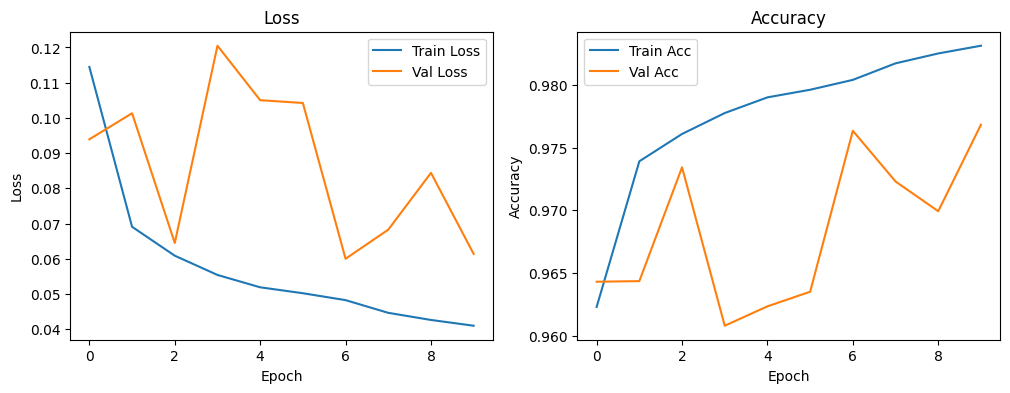

In [14]:
plt.figure(figsize=(12,4))
# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 6. Sample Prediction
Let's visualize how the model performs on a few validation samples.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


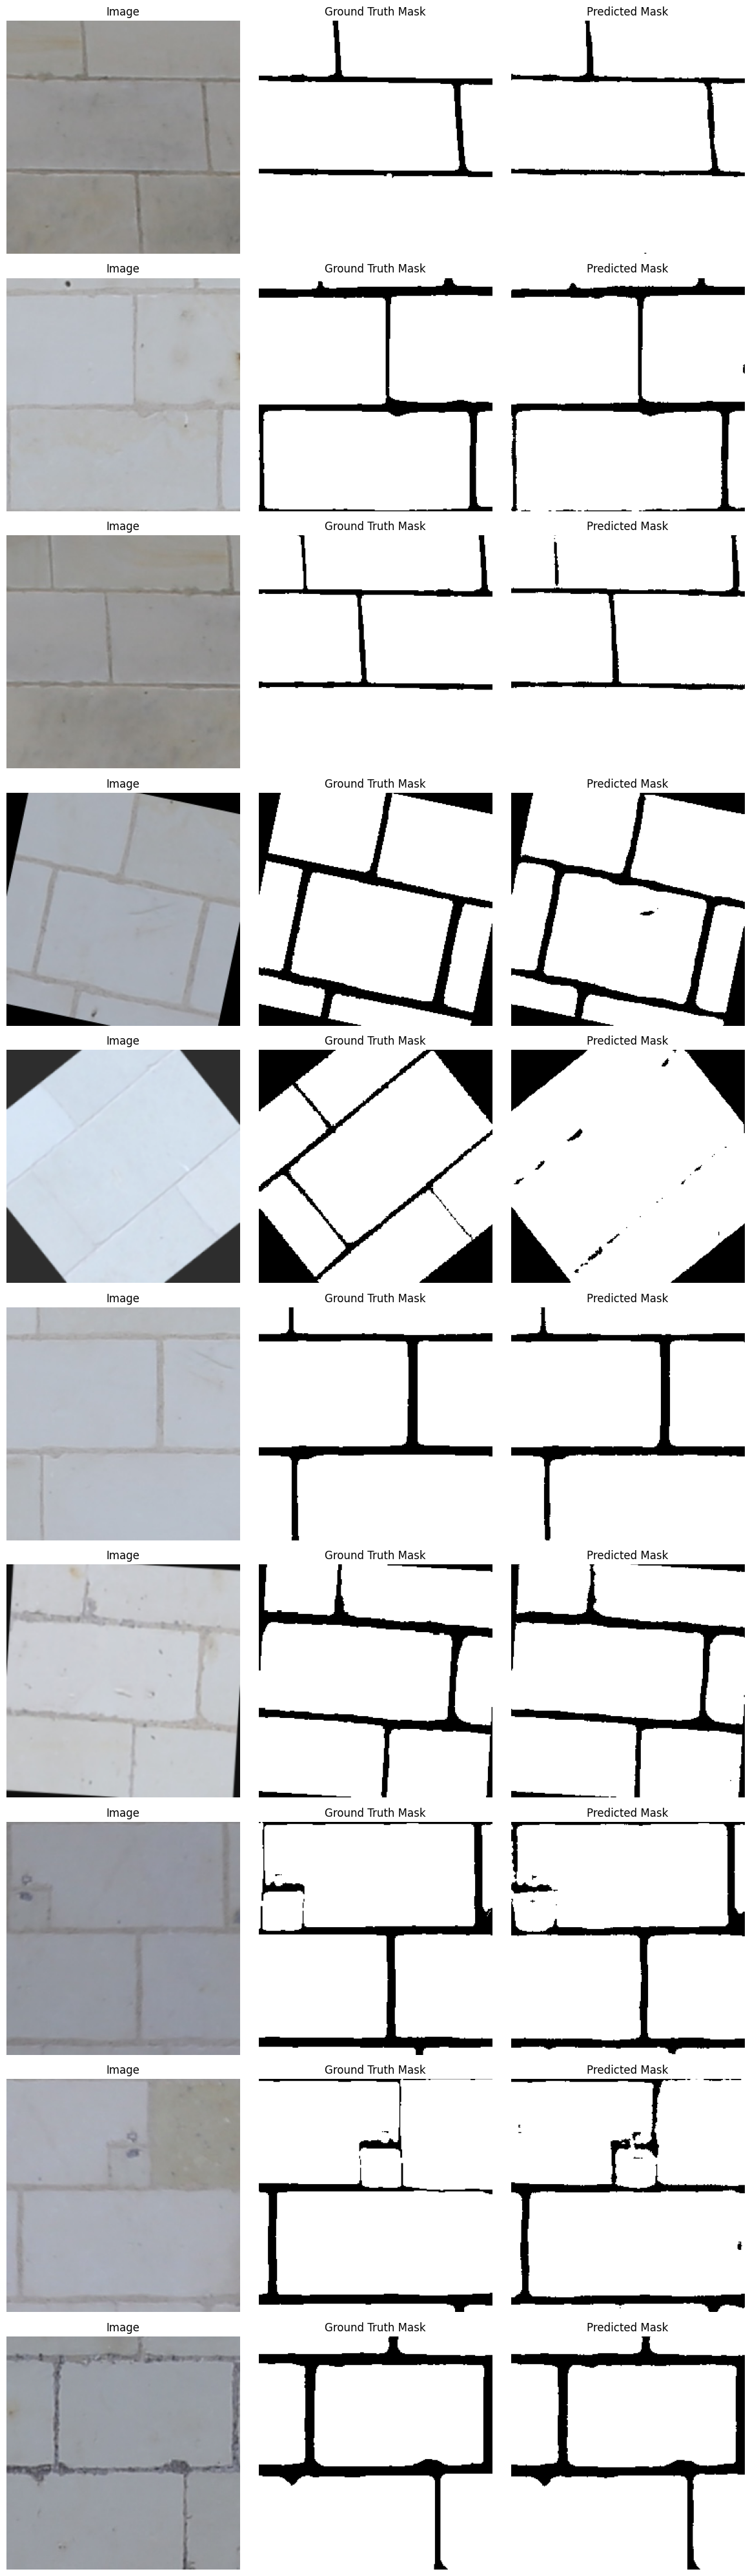

In [17]:
def visualize_predictions(model, image_paths, mask_paths, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_samples=3):
    # Ensure we don't exceed the available samples
    num_samples = min(num_samples, len(image_paths))
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    # If only a single sample is provided, wrap axs into a list for consistency.
    if num_samples == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i in range(num_samples):
        # Load and preprocess image/mask
        img = load_image(image_paths[i], target_size=input_size, grayscale=False)
        mask = load_image(mask_paths[i], target_size=input_size, grayscale=True)
        img_scaled = img / 255.0
        mask_scaled = mask / 255.0
        
        # Expand dims and predict
        pred = model.predict(np.expand_dims(img_scaled, axis=0))
        if NUM_CLASSES == 2:
            pred_mask = (pred[0, :, :, 0] > 0.5).astype(np.uint8)
        else:
            pred_mask = np.argmax(pred[0], axis=-1)
        
        # Plot image, ground truth, and prediction
        axs[i, 0].imshow(img.astype(np.uint8))
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(mask_scaled[:, :, 0], cmap='gray')
        axs[i, 1].set_title('Ground Truth Mask')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage: Visualize 10 samples from the validation set.
visualize_predictions(model, val_images, val_masks, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_samples=10)


## 7. Saving the Model
Finally, let's save the trained model to the `models/` directory so we can reuse it.

In [ ]:
SAVE_PATH = "../models/segnet_chambord.keras"
model.save(SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")

Model saved to ../models/segnet_chambord.keras
